# Dataset 1: Boston Housing Prices

Dataset available from kaggle here: https://www.kaggle.com/datasets/vikrishnan/boston-house-prices

In [44]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

## Data Preparation and Exploration

The following steps are taken to prepare the data for analysis and model development:

1. Plot data correlation between variables to help identify relationships or dependencies between features
2. Plot data distribution per variable to identify any skew or outliers in each feature
3. Data cleaning (removal of outliers) to ensure data validity

Outliers are identified in the RM (average number of rooms per dwelling) feature and removed to not influence the models.

In [3]:
headers = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE',
           'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

df_D1 = pd.read_csv('housing.csv', sep='\s+', names=headers)
df_D1.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


### Visualising variable correlation

<AxesSubplot:>

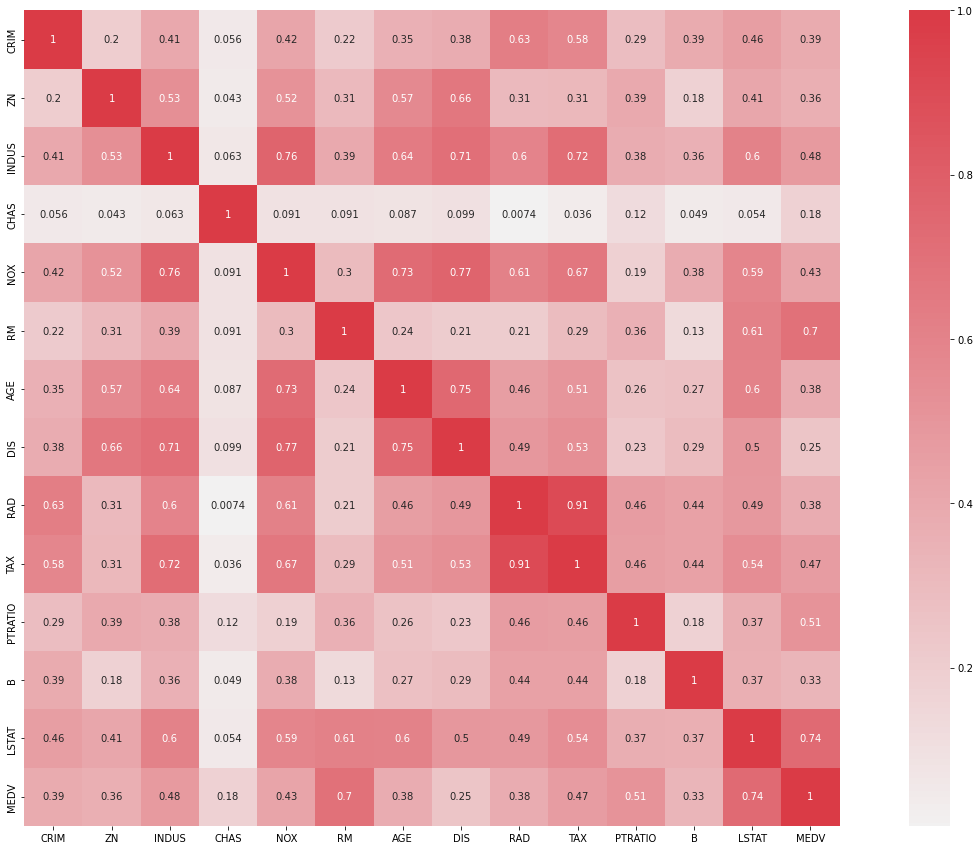

In [4]:
plt.figure(figsize=(25, 15))
cmap = sns.diverging_palette(500, 10, as_cmap=True)
sns.heatmap(df_D1.corr().abs(), cmap=cmap, center=0, square=True, annot=True)

### Visualising data distribution for each variable

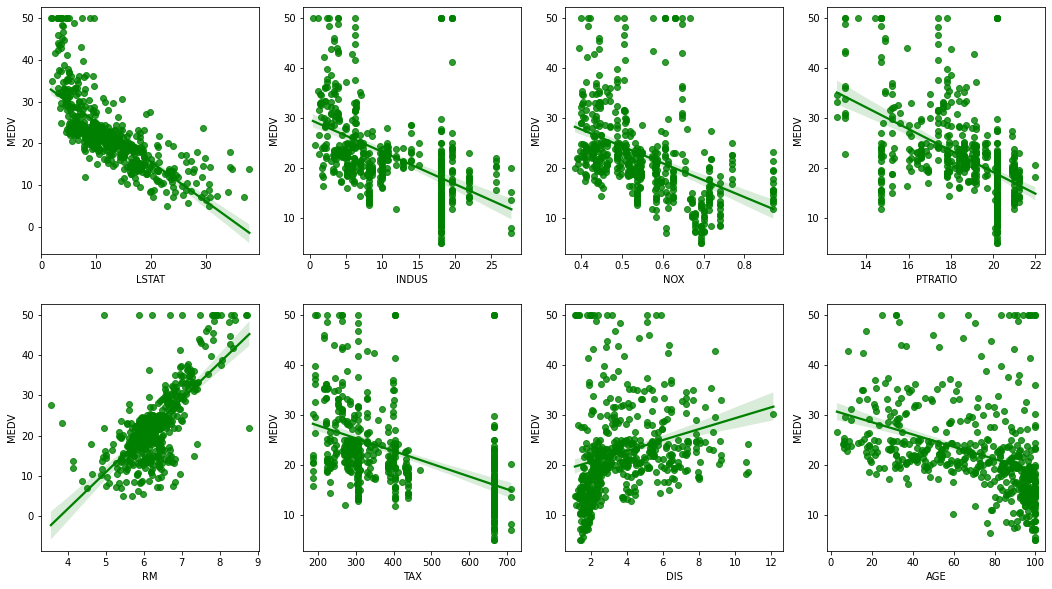

In [5]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(18,10))
cols = ['LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE']
for col, ax in zip(cols, axs.flat):
    sns.regplot(x = df_D1[col],y = df_D1['MEDV'], color = 'green', ax=ax)

### Find and remove outliers

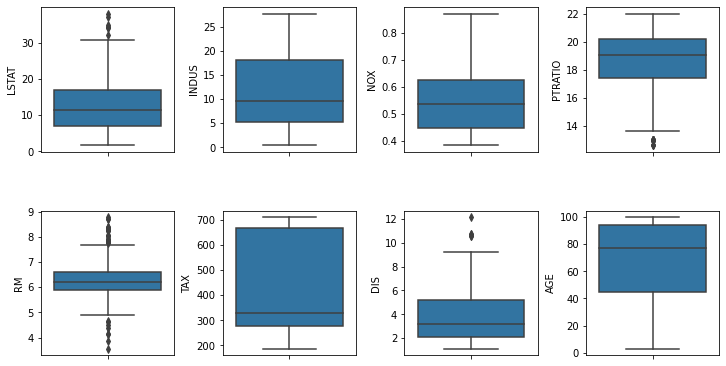

In [6]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(10, 5))
index = 0
axs = axs.flatten()

for i,j in df_D1[cols].items():
    sns.boxplot(y=i, data=df_D1[cols], ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [7]:
df_D1 = df_D1[~((df_D1['RM'] >= 8.5) | (df_D1['RM'] < 4))]

### Train-test split

In [8]:
y = df_D1['MEDV']
X = df_D1[cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                   random_state=2)

### Scaling

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_test = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test)

## Model Development

The task associated with this dataset is regression, with non-linear dependencies between features. The following models, that are suited for non-linear relationships, will be selected:

1. Support Vector Machine: For its ability to handle high-dimensional data
2. Multi Level Perceptron: For its ability to handle complex relationships between features
3. Decision Tree: Less suited than the other models. However, Decision trees are interpretable, allowing us to understand the decision-making process and identify important features. It can provide insights into feature importance and offer a baseline model for comparison with other models. 

The algorithm parameters are systematically set by using GridSearchCV to obtain tuned hyper-parameters. The optimal parameters are displayed for each model.

The models are evaluated with the following metrics:

1. MSE: Measures the average squared difference between the predicted and actual values in a regression model. MSE provides a measure of the overall model performance by quantifying the average magnitude of errors. A lower MSE indicates better model performance, as it signifies smaller errors between the predicted and actual values.

2. R-squared: Measures the proportion of variance in the dependent variable (target) that is explained by the independent variables (features) in a regression model. R-squared ranges from 0 to 1, where 0 indicates that the model explains none of the variance, and 1 indicates that the model explains all the variance in the target variable. R-squared provides an assessment of how well the model fits the data. A higher R-squared value suggests a better fit and indicates that a larger proportion of the variance is captured by the model.

Results are collected and plotted with scatterplots demonstrating model fit.

In [10]:
### BASELINE ###

# Initialize the linear regression model
lr_model = LinearRegression()
# Train the model on the training set
lr_model.fit(X_train, y_train)
# Make predictions on the testing set
lr_predictions = lr_model.predict(X_test)

# Evaluate the linear regression model
lr_mse = mean_squared_error(y_test, lr_predictions)
lr_r2 = r2_score(y_test, lr_predictions)
print('Linear Regression:')
print('MSE:', lr_mse)
print('R-squared:', lr_r2)

Linear Regression:
MSE: 21.320494213059046
R-squared: 0.7514980481388833


In [11]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the decision tree regressor model
dt_model = DecisionTreeRegressor(random_state=42)

# Initialize the grid search with cross-validation
grid_search = GridSearchCV(dt_model, param_grid, cv=5)

# Train the model on the training set with hyperparameter tuning
grid_search.fit(X_train, y_train)

# Get the best model with tuned hyperparameters
dt_model = grid_search.best_estimator_

# Make predictions on the testing set
dt_predictions = dt_model.predict(X_test)

# Evaluate the decision tree regressor model with tuned hyperparameters
dt_mse = mean_squared_error(y_test, dt_predictions)
dt_r2 = r2_score(y_test, dt_predictions)

print('Decision Tree Regressor (Tuned Hyperparameters):')
print('Best Hyperparameters:', grid_search.best_params_)
print('MSE:', dt_mse)
print('R-squared:', dt_r2)


Decision Tree Regressor (Tuned Hyperparameters):
Best Hyperparameters: {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2}
MSE: 13.831751354490097
R-squared: 0.8387834177341397


In [55]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'hidden_layer_sizes': [(64,), (128,), (64, 32), (128, 64)],
    'max_iter': [100, 200, 500, 1000]
}

# Initialize the MLPRegressor model
mlp_model = MLPRegressor(activation='relu', solver='adam', random_state=42)

# Initialize the grid search with cross-validation
grid_search = GridSearchCV(mlp_model, param_grid, cv=5)

# Train the model on the training set with hyperparameter tuning
grid_search.fit(X_train, y_train)

# Get the best model with tuned hyperparameters
mlp_model = grid_search.best_estimator_

# Make predictions on the testing set
nn_predictions = mlp_model.predict(X_test)

# Evaluate the MLPRegressor model with tuned hyperparameters
nn_mse = mean_squared_error(y_test, nn_predictions)
nn_r2 = r2_score(y_test, nn_predictions)

print('Neural Network Regressor (Tuned Hyperparameters):')
print('Best Hyperparameters:', grid_search.best_params_)
print('MSE:', nn_mse)
print('R-squared:', nn_r2)


Neural Network Regressor (Tuned Hyperparameters):
Best Hyperparameters: {'hidden_layer_sizes': (128, 64), 'max_iter': 1000}
MSE: 10.065996211632147
R-squared: 0.8826753413396465


In [37]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.1, 0.2, 0.5]
}

# Initialize the SVM regression model
svr_model = SVR(kernel='rbf')

# Initialize the grid search with cross-validation
grid_search = GridSearchCV(svr_model, param_grid, cv=5)

# Train the model on the training set with hyperparameter tuning
grid_search.fit(X_train, y_train)

# Get the best model with tuned hyperparameters
svr_model = grid_search.best_estimator_

# Make predictions on the testing set
svr_predictions = svr_model.predict(X_test)

# Evaluate the SVM regression model with tuned hyperparameters
svr_mse = mean_squared_error(y_test, svr_predictions)
svr_r2 = r2_score(y_test, svr_predictions)

print('Support Vector Regression (Tuned Hyperparameters):')
print('Best Hyperparameters:', grid_search.best_params_)
print('MSE:', svr_mse)
print('R-squared:', svr_r2)


Support Vector Regression (Tuned Hyperparameters):
Best Hyperparameters: {'C': 10, 'epsilon': 0.5, 'gamma': 'scale'}
MSE: 7.5366140646828566
R-squared: 0.9121566654702364


## Insights

In [14]:
# Get the feature importances from the Decision Tree model
importance_scores = dt_model.feature_importances_

# Create a list of tuples containing feature names and their importance scores
feature_importances = list(zip(headers, importance_scores))

# Sort the features based on their importance scores in descending order
feature_importances.sort(key=lambda x: x[1], reverse=True)

# Print the top N most important features
N = 10  # Number of top features to display
for feature, importance in feature_importances[:N]:
    print(f"{feature}: {importance}")

CRIM: 0.5818997388197995
NOX: 0.2630104088484358
AGE: 0.0919193614870425
INDUS: 0.02631885863406836
DIS: 0.011395316112424812
CHAS: 0.009721407805360049
RM: 0.008342541832918333
ZN: 0.007392366459950586


## Evaluation Discussion

### Interpretability 
In terms of interpretability, the Decision Tree model does much better than the MLP and SVM as it consists of a hierarchical structure of nodes and splits, making it easy to understand and explain the decision-making process. It allows us to identify important features and their impact on predicting housing prices. The complex architecture of the MLP model and high dimensional feature space built by the SVM model reduces the interpretability of these models.

### Generalization
The SVR achieves the highest R-squared score of 0.9122, indicating a strong ability to explain the variance in the target variable. It captures approximately 91.22% of the underlying patterns, suggesting excellent generalization performance. The MLP also gets a high R-squared score of 0.8827 only slightly less than SVR. SVR uses a kernel function to transform the data into a higher-dimensional space, while MLP has multiple layers of interconnected neurons. This flexibility allows them to capture more intricate relationships between features and the target variable. The decision tree model on the other hand makes predictions based on simple rules according to its hierarchical structure. This structure may not capture complex relationships in the data, limiting its ability to explain the variance.

### Significance
The decision tree model provided valuable insights about the Boston Housing dataset through the feature importances. They indicate the relative importance of each feature in the model's decision-making process. In this case, the top three most important features were "CRIM" (per capita crime rate by town), "NOX" (nitric oxides concentration), and "AGE" (proportion of owner-occupied units built prior to 1940).

The high importance assigned to "CRIM" suggests that the crime rate has a significant impact on housing prices. Areas with higher crime rates tend to have lower housing prices, indicating that safety and security play a crucial role in determining property values. Similarly, the importance of "NOX" implies that the level of nitric oxides, which are air pollutants, has an adverse effect on housing prices. Areas with higher concentrations of nitric oxides may have reduced desirability and, thus, lower housing prices.

The feature importance of "AGE" indicates that the age of the buildings in a town influences housing prices. Older buildings may have lower values due to potential maintenance issues or outdated amenities.

Additionally, the relatively lower importances assigned to features like "DIS" (weighted distances to employment centers), "CHAS" (proximity to the Charles River), "RM" (average number of rooms per dwelling), and "ZN" (proportion of residential land zoned for lots over 25,000 sq.ft.) suggest that these factors have less influence on housing prices in comparison to the top three features.

## Result Visualisations

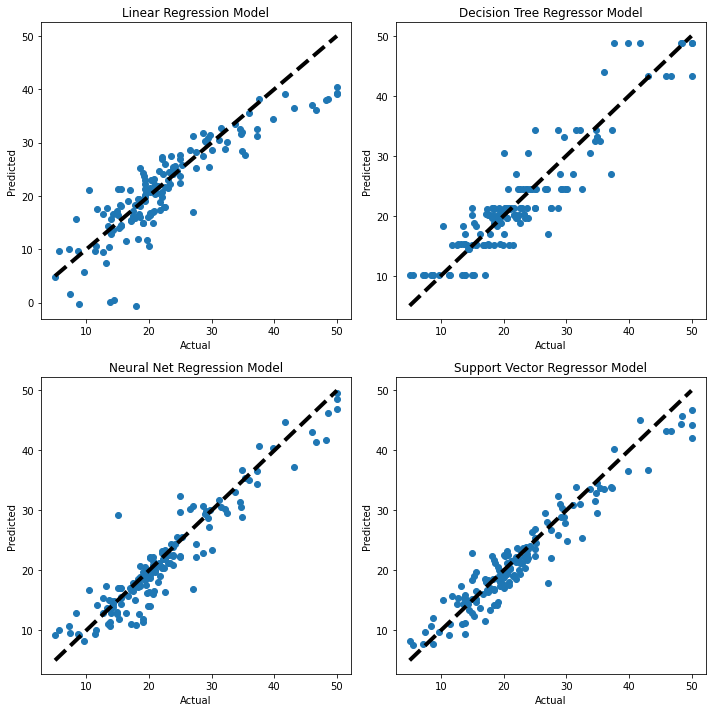

In [56]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Scatter plot for the linear regression model
axs[0, 0].scatter(y_test, lr_predictions)
axs[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
axs[0, 0].set_xlabel('Actual')
axs[0, 0].set_ylabel('Predicted')
axs[0, 0].set_title('Linear Regression Model')

# Scatter plot for the decision tree regressor model
axs[0, 1].scatter(y_test, dt_predictions)
axs[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
axs[0, 1].set_xlabel('Actual')
axs[0, 1].set_ylabel('Predicted')
axs[0, 1].set_title('Decision Tree Regressor Model')

# Scatter plot for the neural net regression model
axs[1, 0].scatter(y_test, nn_predictions)
axs[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
axs[1, 0].set_xlabel('Actual')
axs[1, 0].set_ylabel('Predicted')
axs[1, 0].set_title('Neural Net Regression Model')

# Scatter plot for the SVM regressor model
axs[1, 1].scatter(y_test, svr_predictions)
axs[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
axs[1, 1].set_xlabel('Actual')
axs[1, 1].set_ylabel('Predicted')
axs[1, 1].set_title('Support Vector Regressor Model')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


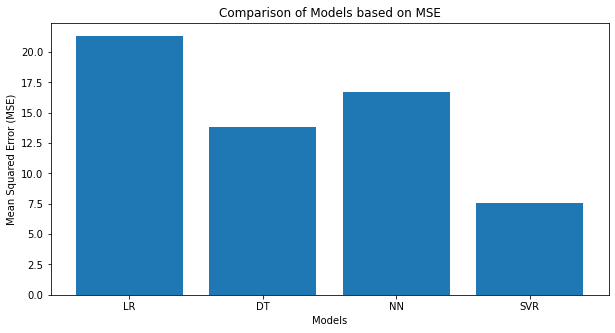

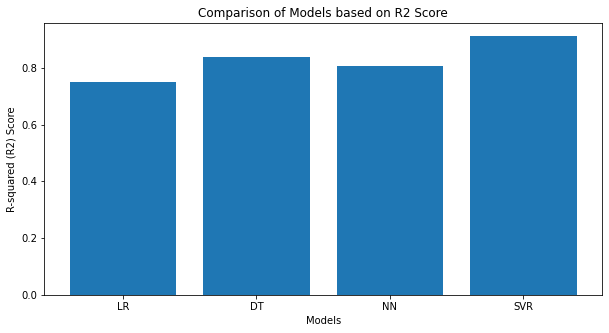

In [39]:


# Model names and scores
model_names = ["LR", "DT", "NN", "SVR"]
mse_scores = [lr_mse, dt_mse, nn_mse, svr_mse]
r2_scores = [lr_r2, dt_r2, nn_r2, svr_r2]

# Plotting MSE scores
plt.figure(figsize=(10, 5))
plt.bar(model_names, mse_scores)
plt.xlabel("Models")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Comparison of Models based on MSE")
plt.show()

# Plotting R2 scores
plt.figure(figsize=(10, 5))
plt.bar(model_names, r2_scores)
plt.xlabel("Models")
plt.ylabel("R-squared (R2) Score")
plt.title("Comparison of Models based on R2 Score")
plt.show()
